In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_6')
labels_dir = Path(data_dir, 'labels_4')
models_dir = Path(Path.cwd().parent, 'models')
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size
    
score_names = [
    f'Worse{" "*12}Silhouette{" "*12}Better',
    f'Worse{" "*8}Calinski-Harabasz{" "*8}Better',
    f'Better{" "*10}Davies-Bouldin{" "*10}Worse',
    f'Stable{" "*16}Entropy{" "*16}Unstable'
]

In [3]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

# KMeans

In [4]:
df_kmeans

distance       dataset  n_clusters  sl_score    ch_score   db_score  \
666  euclidean   chains_eq_2           8 -0.001257  424.053598   4.351315   
670  euclidean   chains_eq_2          12 -0.026062  335.658544   4.192407   
671  euclidean   chains_eq_2          13 -0.026415  312.656100   3.805666   
672  euclidean   chains_eq_2          14 -0.037344  300.235491   3.826546   
673  euclidean   chains_eq_2          15 -0.038499  279.107943   3.620898   
..         ...           ...         ...       ...         ...        ...   
458        wmd  chains_ge_10          30 -0.190429    3.671880  16.021896   
459        wmd  chains_ge_10          31 -0.191227    3.580002  16.487243   
460        wmd  chains_ge_10          32 -0.190460    3.526827  16.166989   
447        wmd  chains_ge_10          19 -0.190422    4.504295  19.237116   
449        wmd  chains_ge_10          21 -0.190379    4.217775  18.939819   

      entropy dimensions  order          name  k_noise  method  
666  1.721670         50      0      CL $= 2$        8  KMeans  
670  2.079500         50      0      CL $= 2$       12  KMeans  
671  2.045838         50      0      CL $= 2$       13  KMeans  
672  2.147341         50      0      CL $= 2$       14  KMeans  
673  2.148669         50      0      CL $= 2$       15  KMeans  
..        ...        ...    ...           ...      ...     ...  
458  3.217713        300      3  CL $\geq$ 10       30  KMeans  
459  3.310336        300      3  CL $\geq$ 10       31  KMeans  
460  3.289116        300      3  CL $\geq$ 10       32  KMeans  
447  2.821206        300      3  CL $\geq$ 10       19  KMeans  
449  2.897327        300      3  CL $\geq$ 10       21  KMeans  

[1333 rows x 12 columns]

In [5]:
iter_dataset = iter(df_kmeans.sort_values(by='order')['dataset'].unique())

chains_eq_2


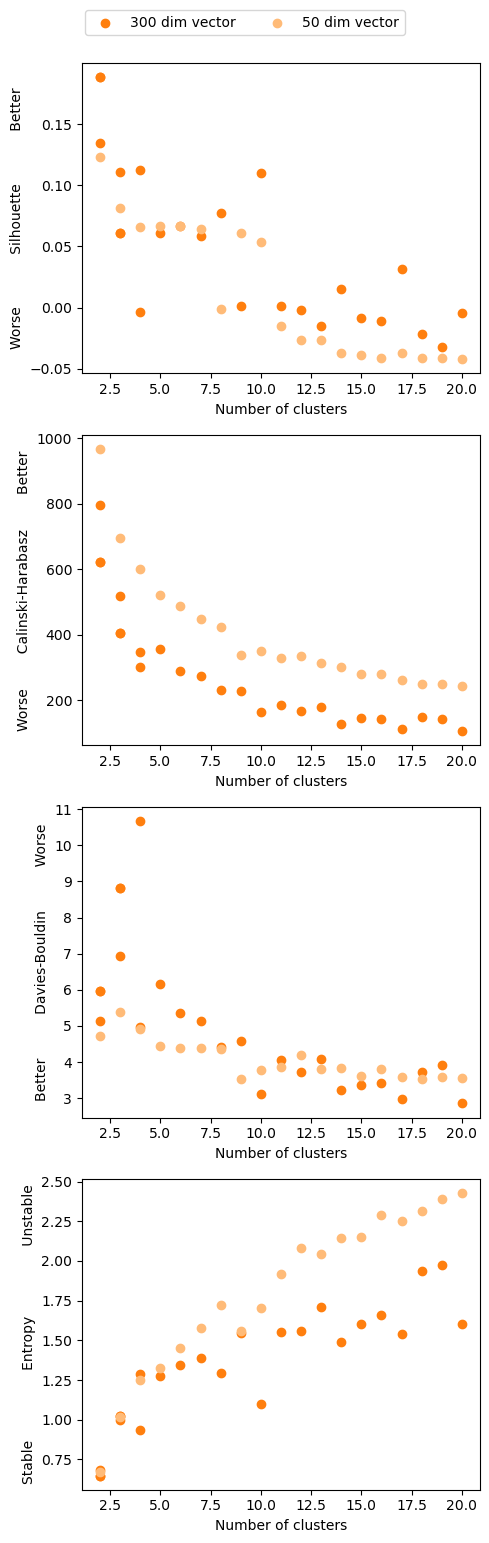

In [6]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=2)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

In [7]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


chains_ge_4_lt_10


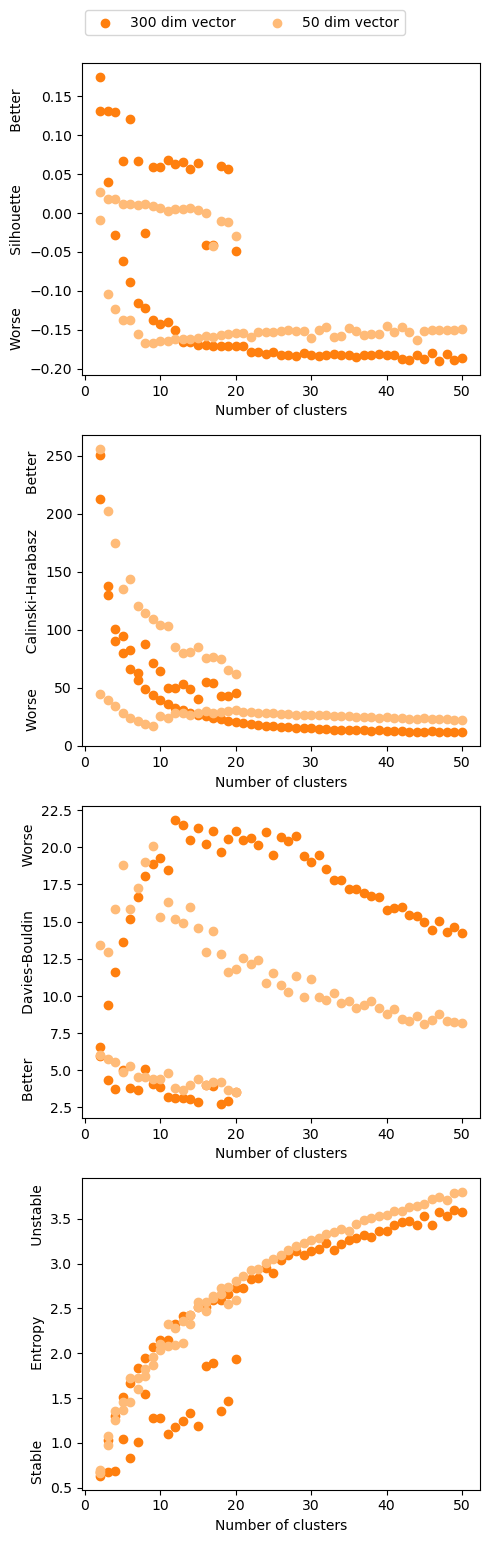

In [8]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


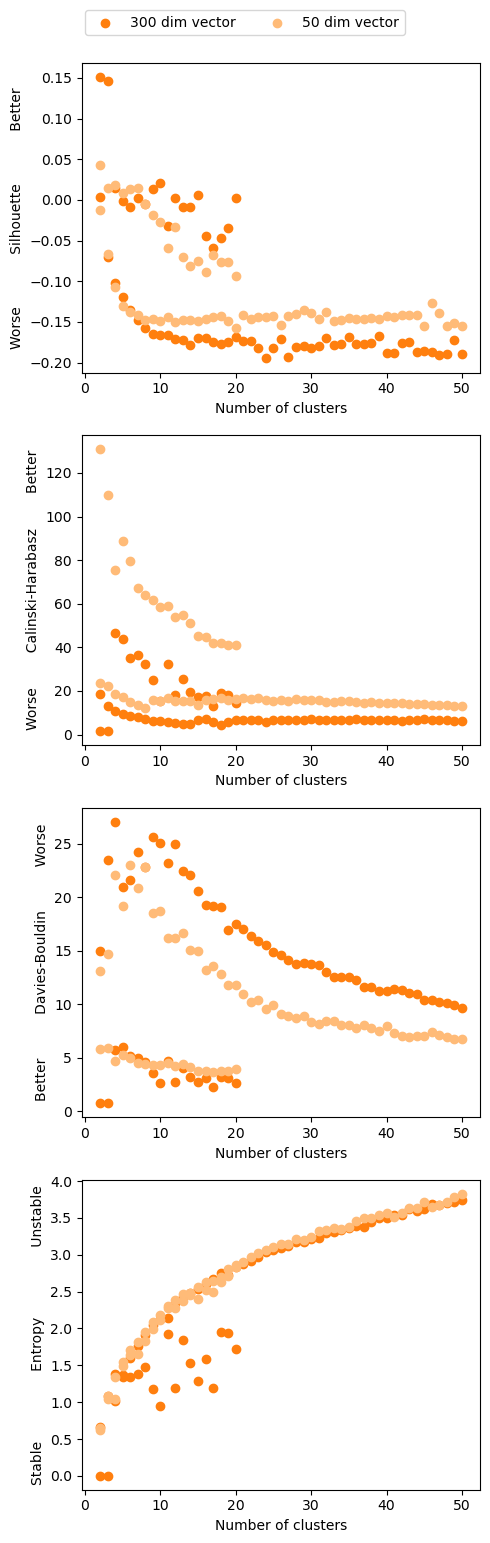

In [9]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

# DBSCAN 

In [10]:
df_dbscan

distance       dataset  epsilon  min_pts  n_clusters  sl_score  \
38917        wmd   chains_eq_2     0.77       13           1       NaN   
41779  euclidean   chains_eq_2     0.27        5           1       NaN   
41780  euclidean   chains_eq_2     0.27        6           1       NaN   
41781  euclidean   chains_eq_2     0.27        7           1       NaN   
41782  euclidean   chains_eq_2     0.27        8           1       NaN   
...          ...           ...      ...      ...         ...       ...   
26600  euclidean  chains_ge_10     0.84        2           3  0.913405   
26601  euclidean  chains_ge_10     0.84        3           2  0.924018   
26602  euclidean  chains_ge_10     0.84        4           2  0.924018   
26574  euclidean  chains_ge_10     0.82        4           2  0.924018   
46703     cosine  chains_ge_10     1.00       15           1       NaN   

          ch_score  db_score   entropy  nn  n_noise  Unnamed: 9   size  \
38917          NaN       NaN       NaN NaN      1.0         NaN  23841   
41779          NaN       NaN       NaN NaN  23527.0         NaN  23841   
41780          NaN       NaN       NaN NaN  23527.0         NaN  23841   
41781          NaN       NaN       NaN NaN  23527.0         NaN  23841   
41782          NaN       NaN       NaN NaN  23527.0         NaN  23841   
...            ...       ...       ...  ..      ...         ...    ...   
26600   662.460079  0.422621  0.496915 NaN   5212.0         NaN   5324   
26601  1227.100908  0.275652  0.414743 NaN   5214.0         NaN   5324   
26602  1227.100908  0.275652  0.414743 NaN   5214.0         NaN   5324   
26574  1227.100908  0.275652  0.414743 NaN   5214.0         NaN   5324   
46703          NaN       NaN       NaN NaN      NaN         NaN   5324   

       prop_noise dimensions  order          name    k_noise  method  
38917    0.000042         50      0      CL $= 2$  1 (0.000)  DBSCAN  
41779    0.986829        300      0      CL $= 2$  1 (0.987)  DBSCAN  
41780    0.986829        300      0      CL $= 2$  1 (0.987)  DBSCAN  
41781    0.986829        300      0      CL $= 2$  1 (0.987)  DBSCAN  
41782    0.986829        300      0      CL $= 2$  1 (0.987)  DBSCAN  
...           ...        ...    ...           ...        ...     ...  
26600    0.978963        300      3  CL $\geq$ 10  3 (0.979)  DBSCAN  
26601    0.979339        300      3  CL $\geq$ 10  2 (0.979)  DBSCAN  
26602    0.979339        300      3  CL $\geq$ 10  2 (0.979)  DBSCAN  
26574    0.979339        300      3  CL $\geq$ 10  2 (0.979)  DBSCAN  
46703         NaN        300      3  CL $\geq$ 10    1 (nan)  DBSCAN  

[46704 rows x 19 columns]

In [11]:
iter_dataset = iter(df_dbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


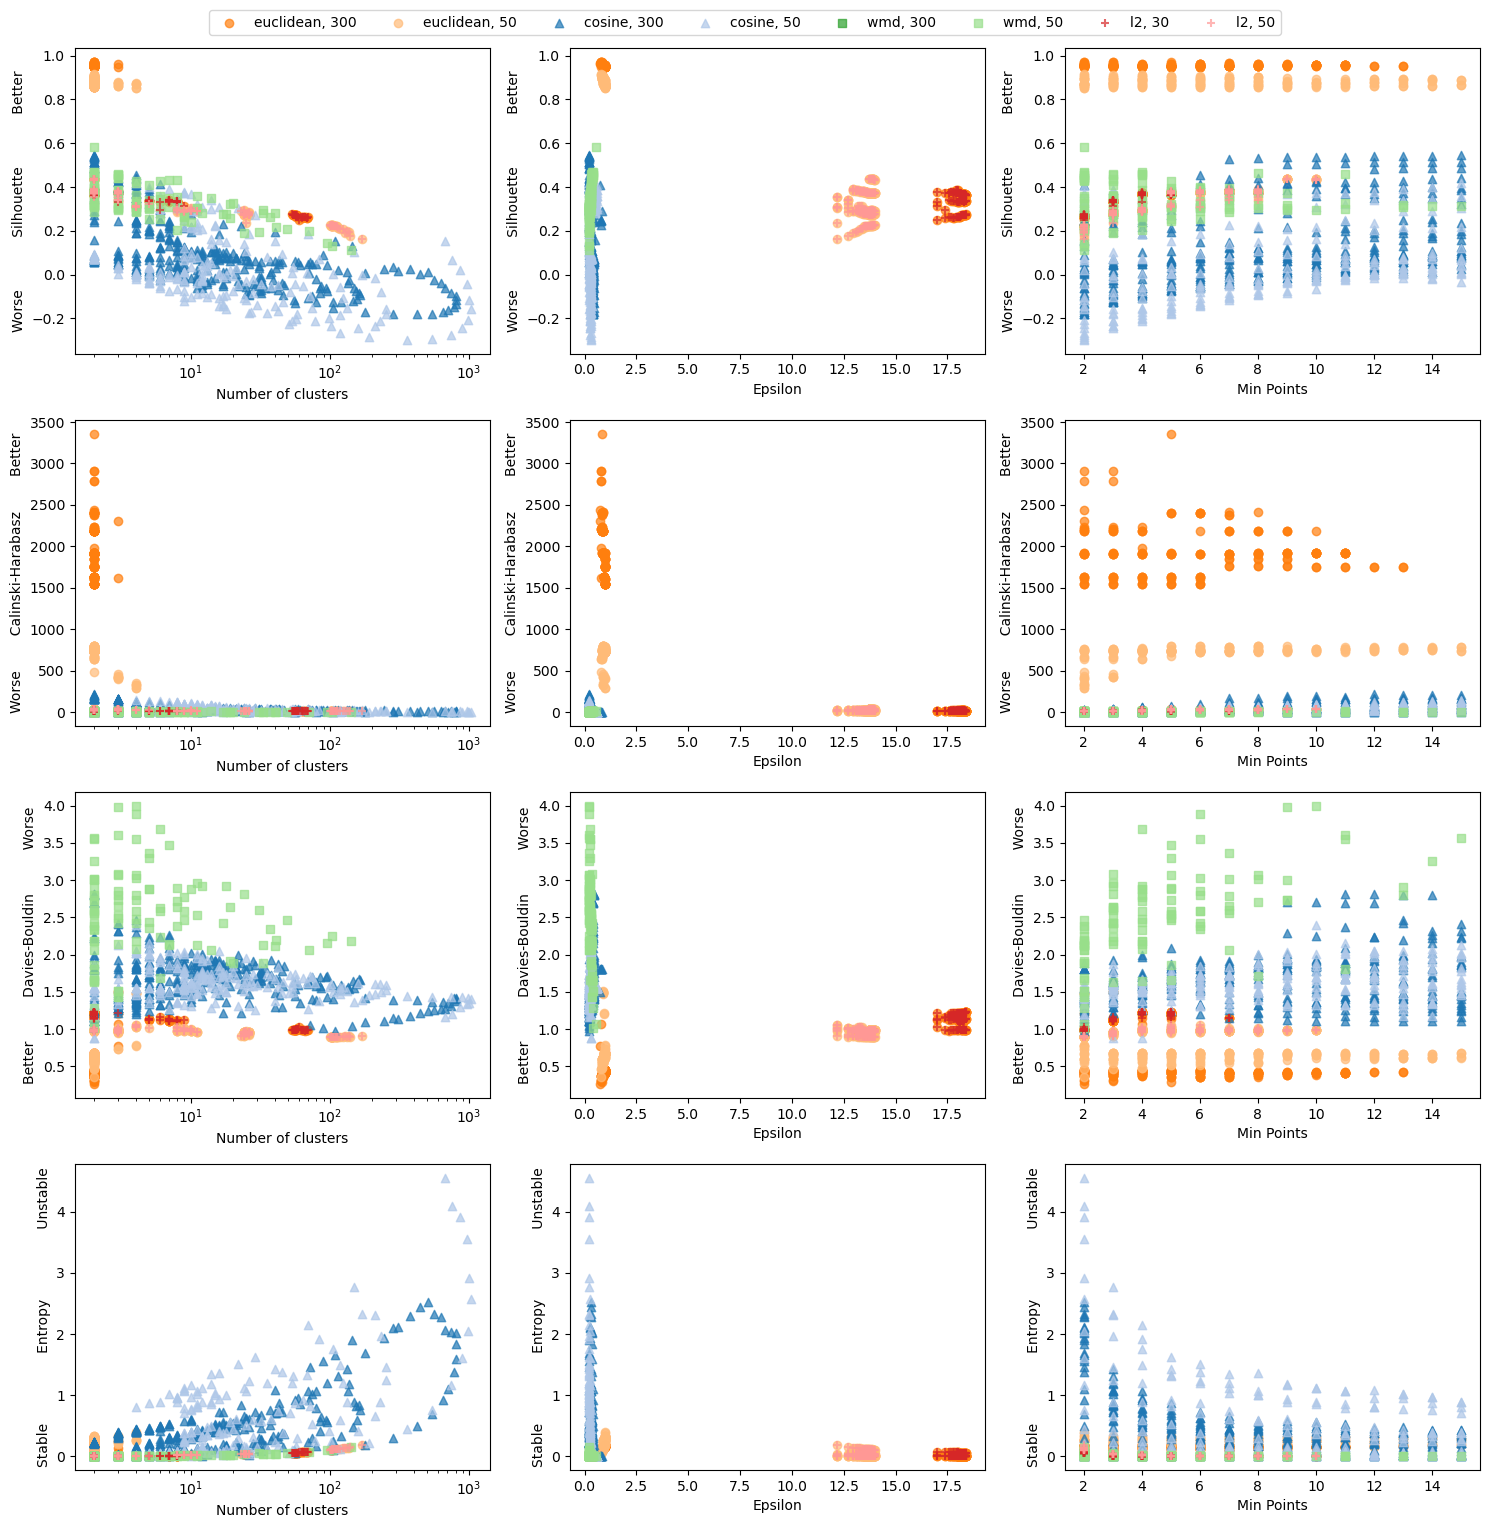

In [12]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_dbscan.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


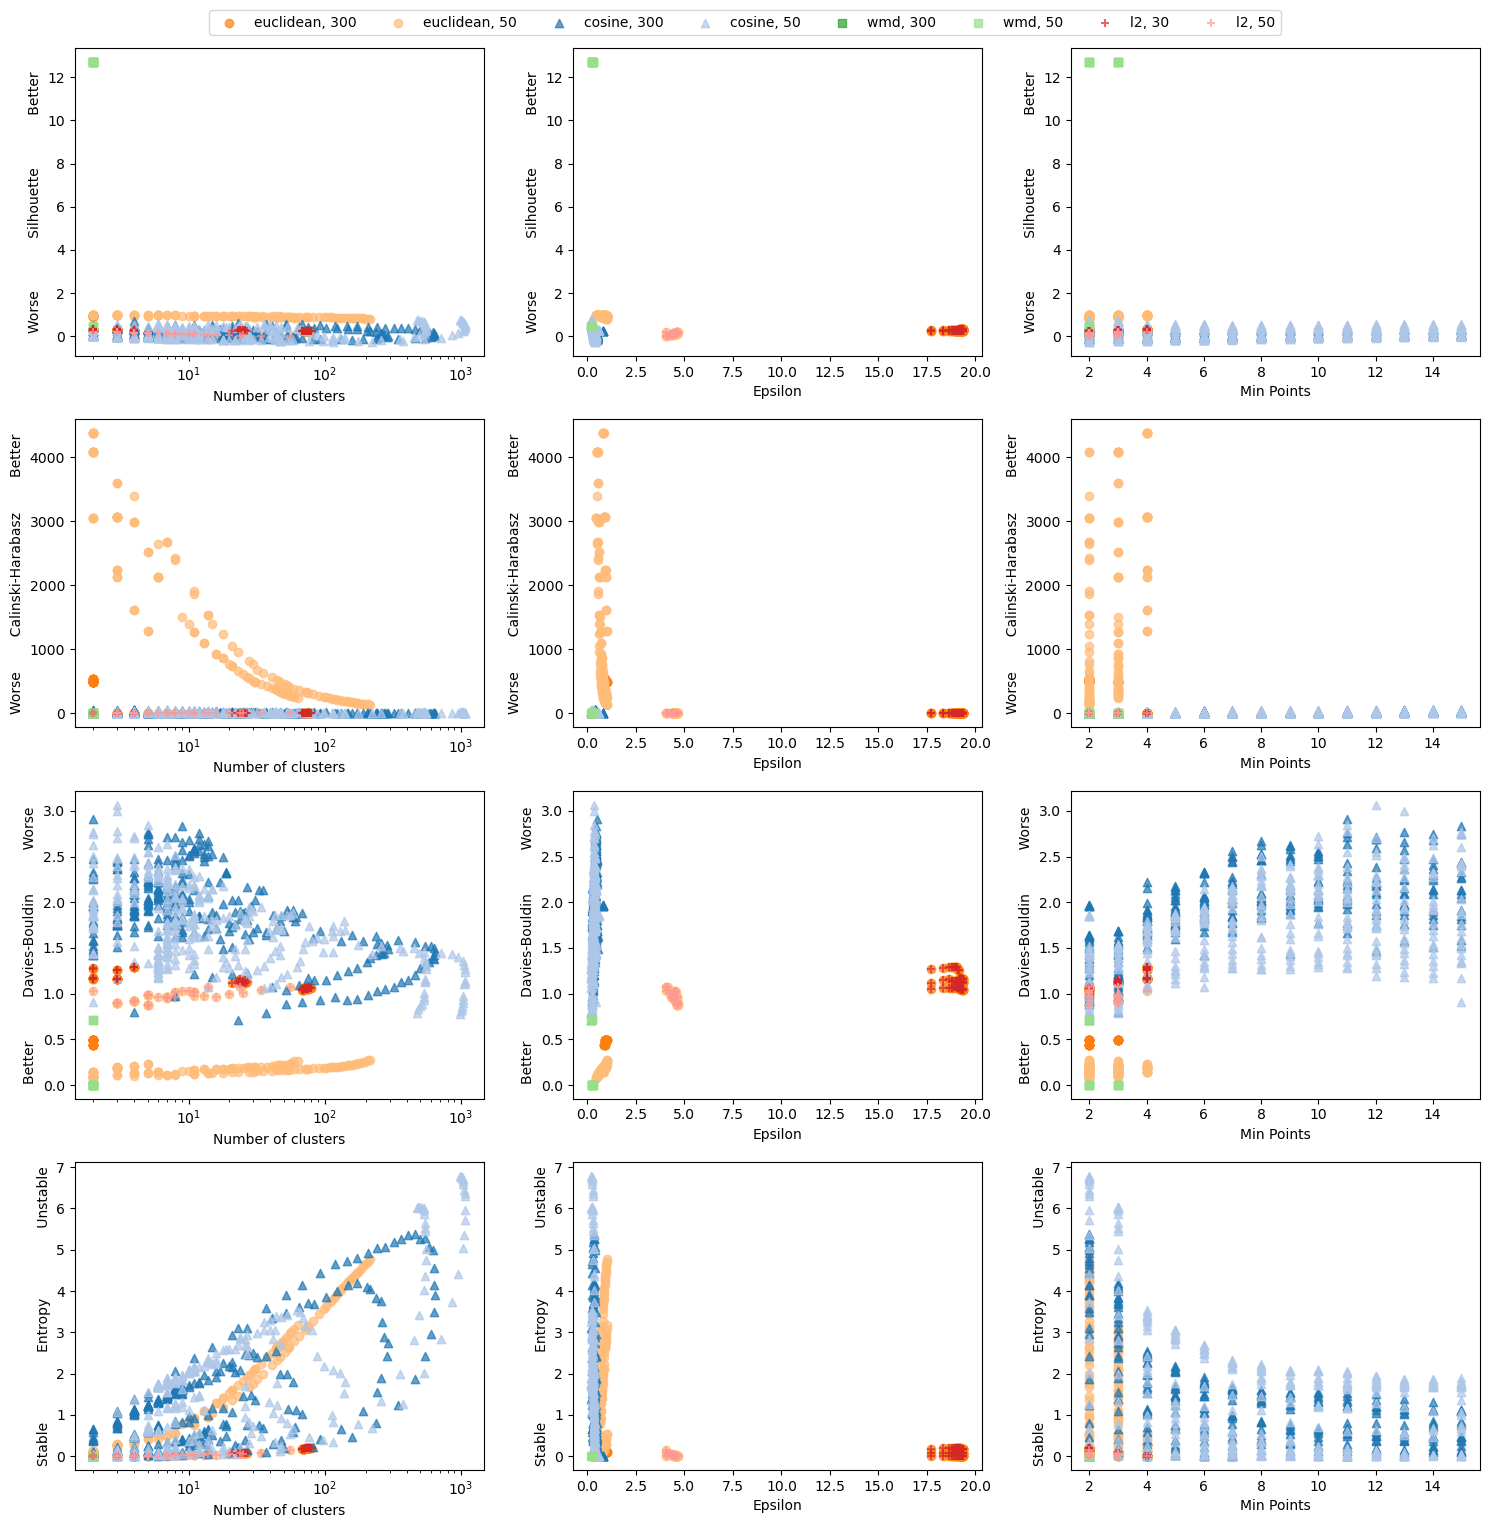

In [13]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


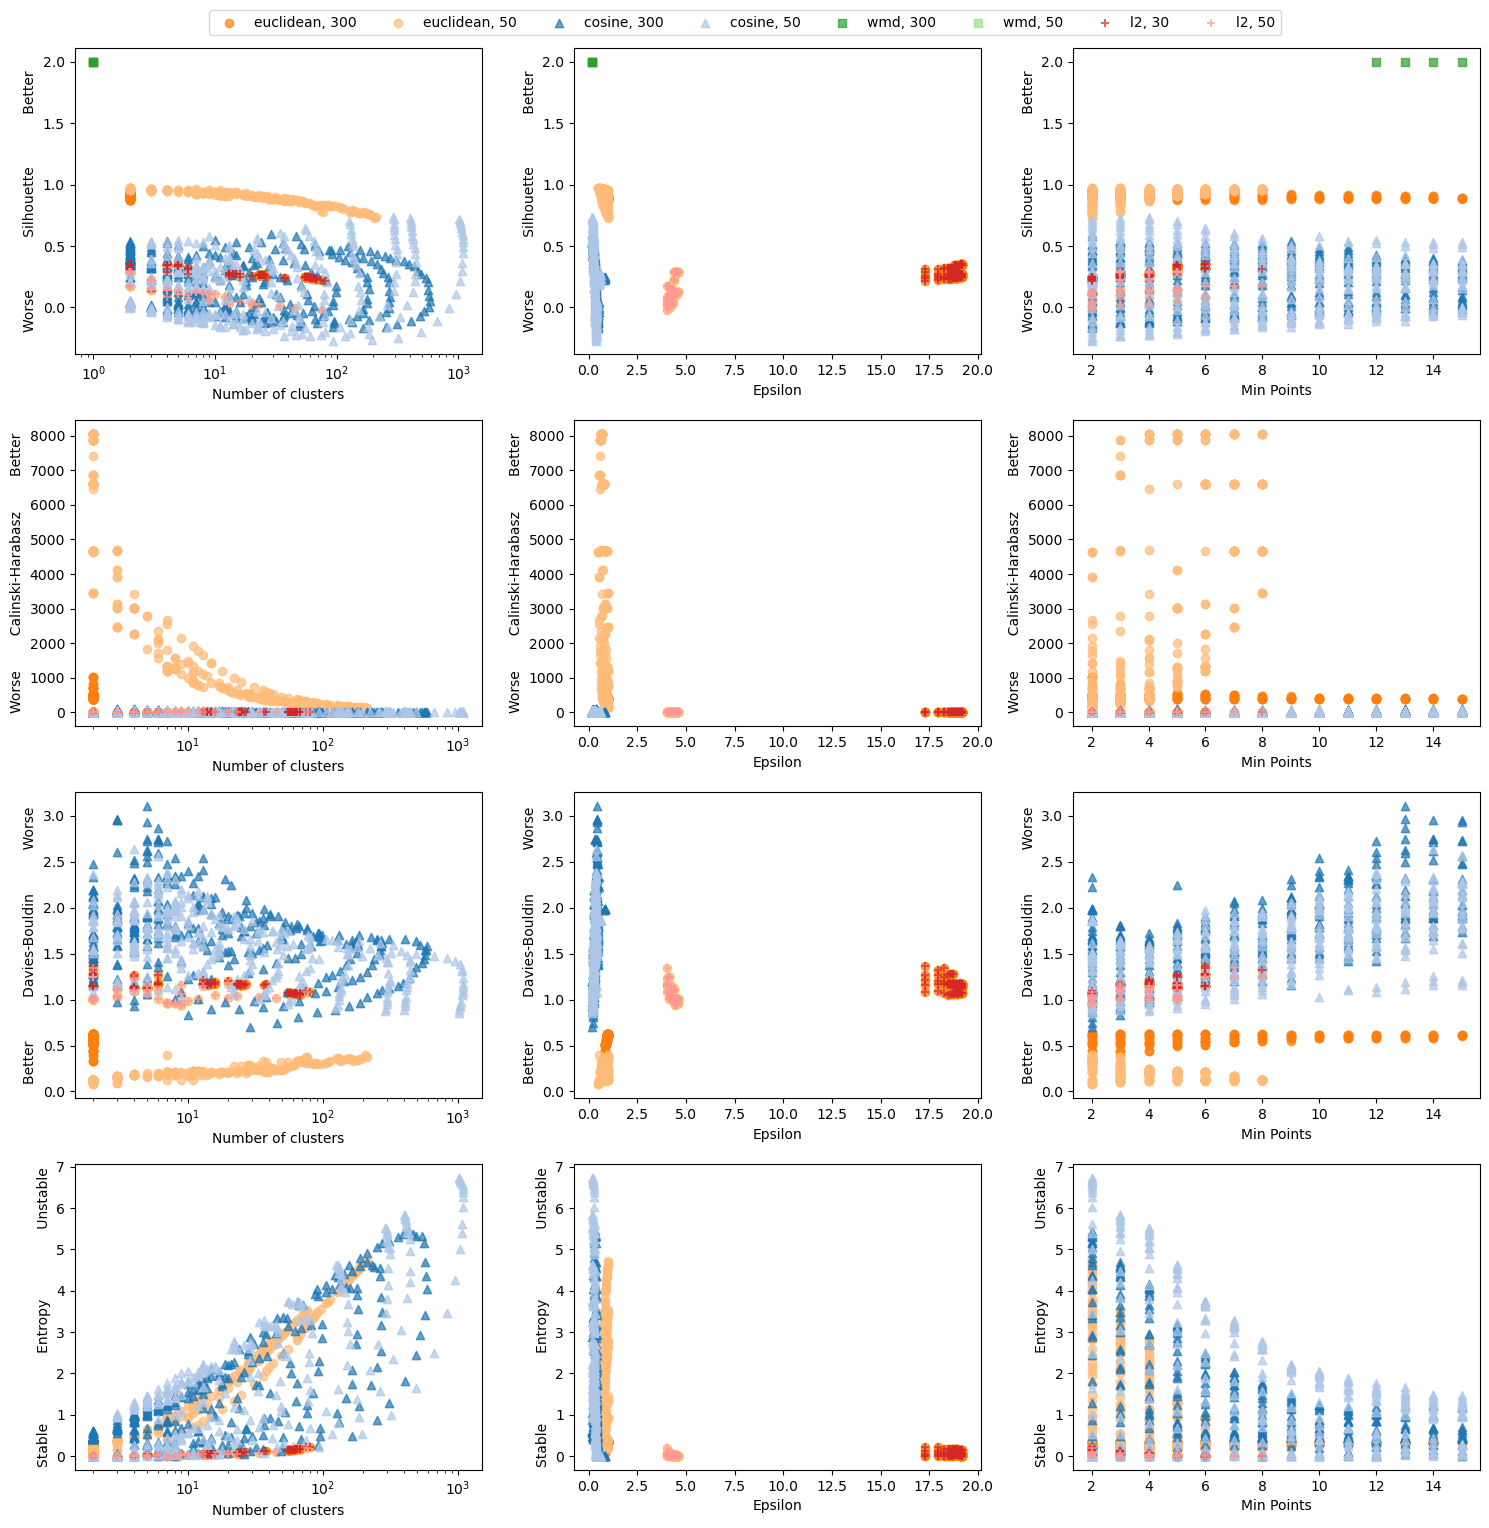

In [14]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


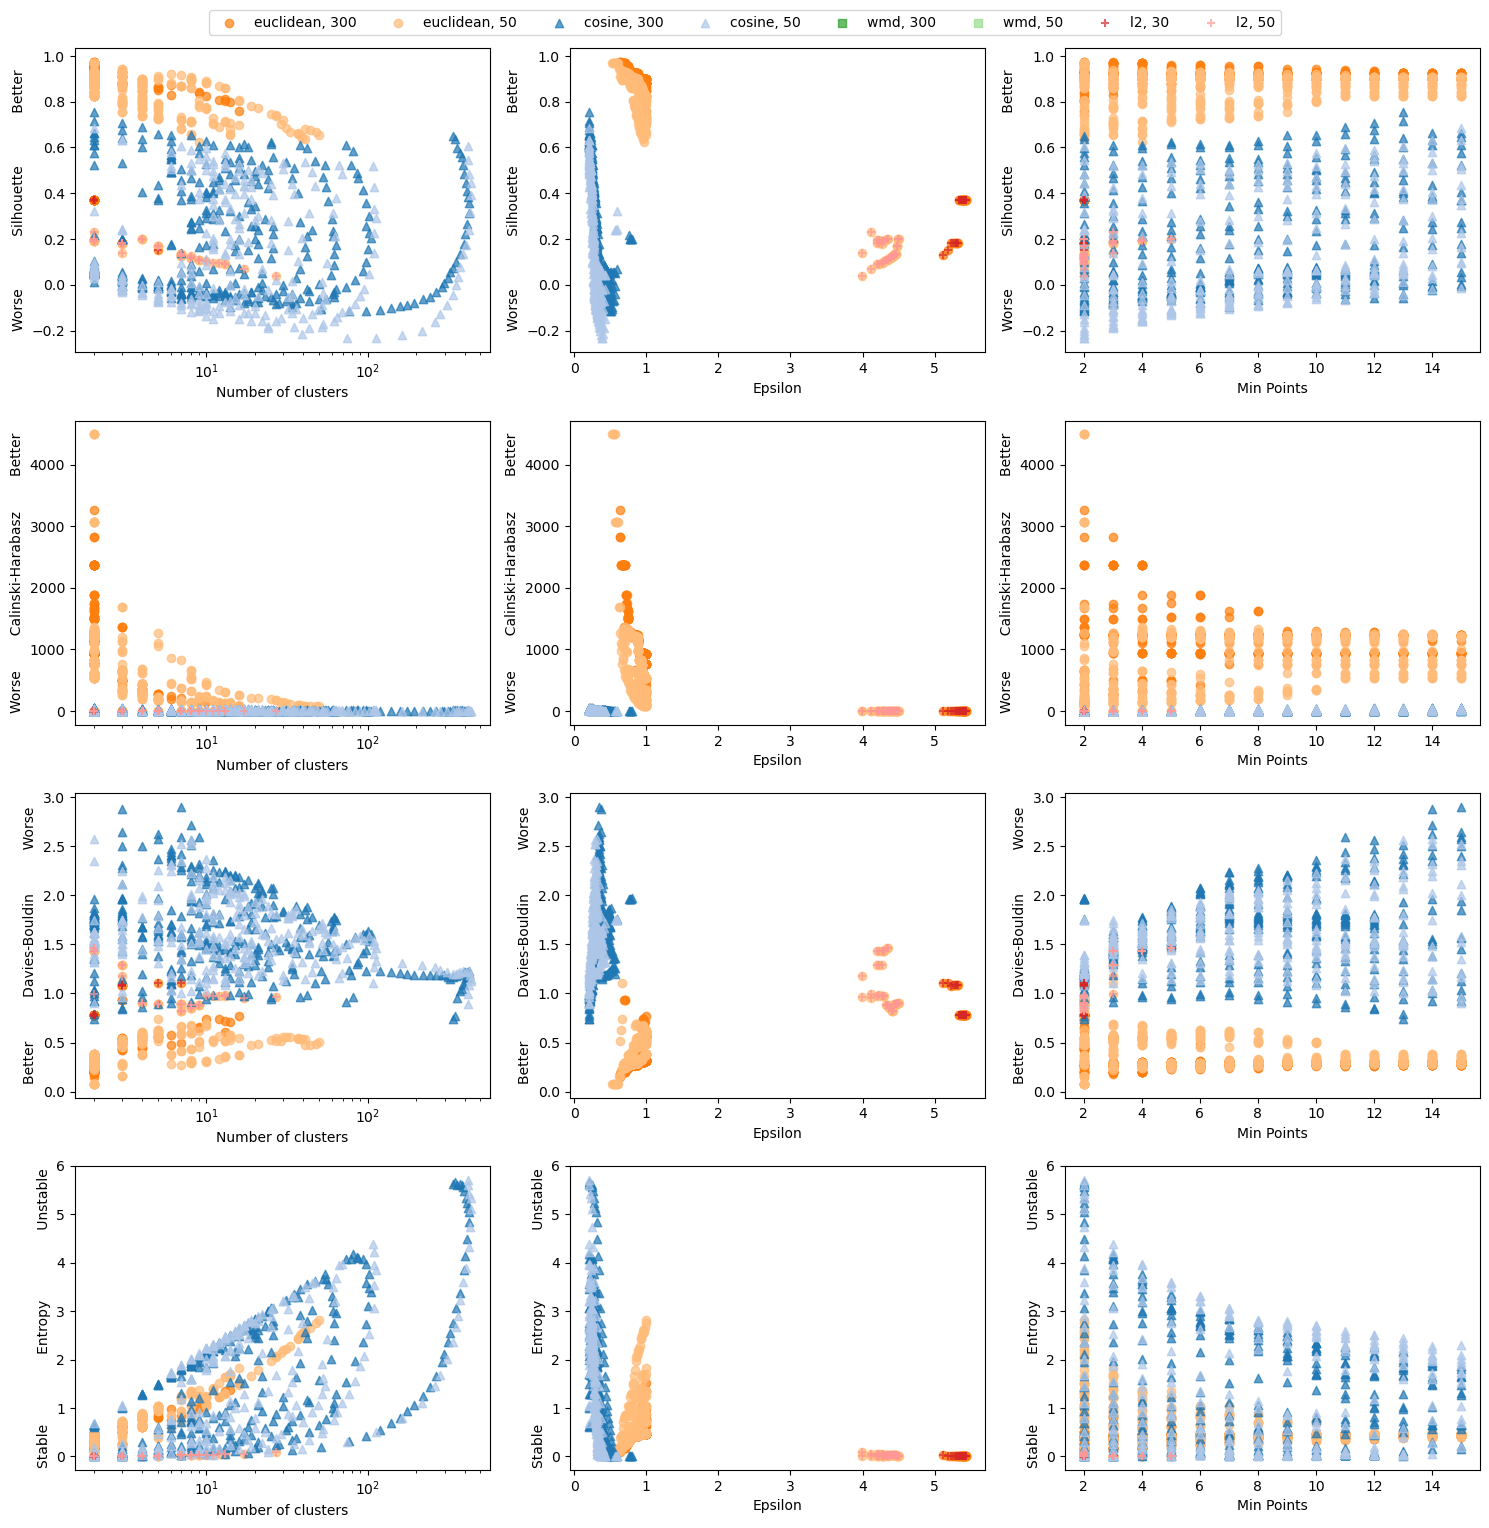

In [15]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

# HDBSCAN

In [22]:
df_hdbscan.sort_values(by='order')['dataset'].unique()

array(['chains_eq_2', 'chains_eq_3', 'chains_ge_4_lt_10', 'chains_ge_10'],
      dtype=object)

In [23]:
iter_dataset = iter(df_hdbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


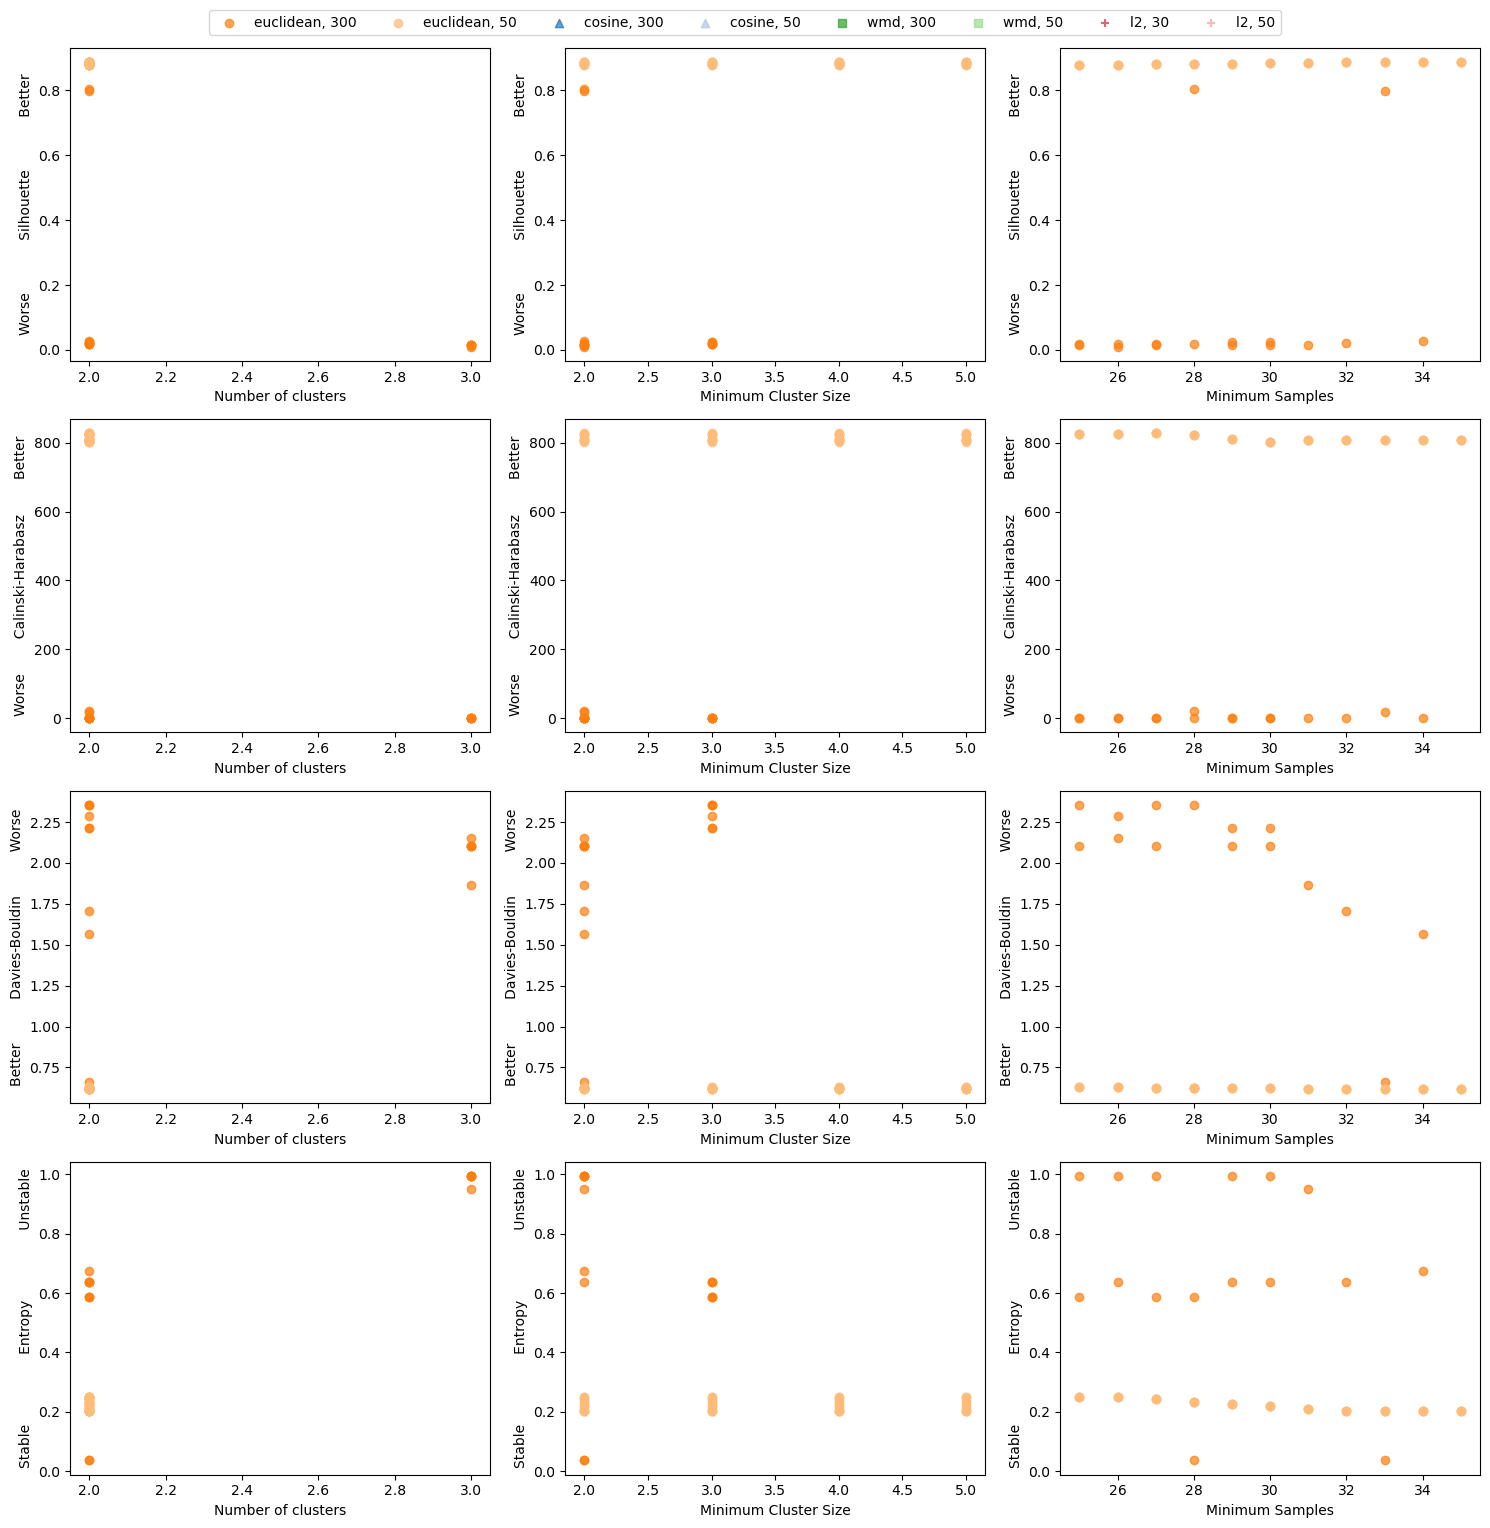

In [24]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        # if params[col] not in params[1:]:
            # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


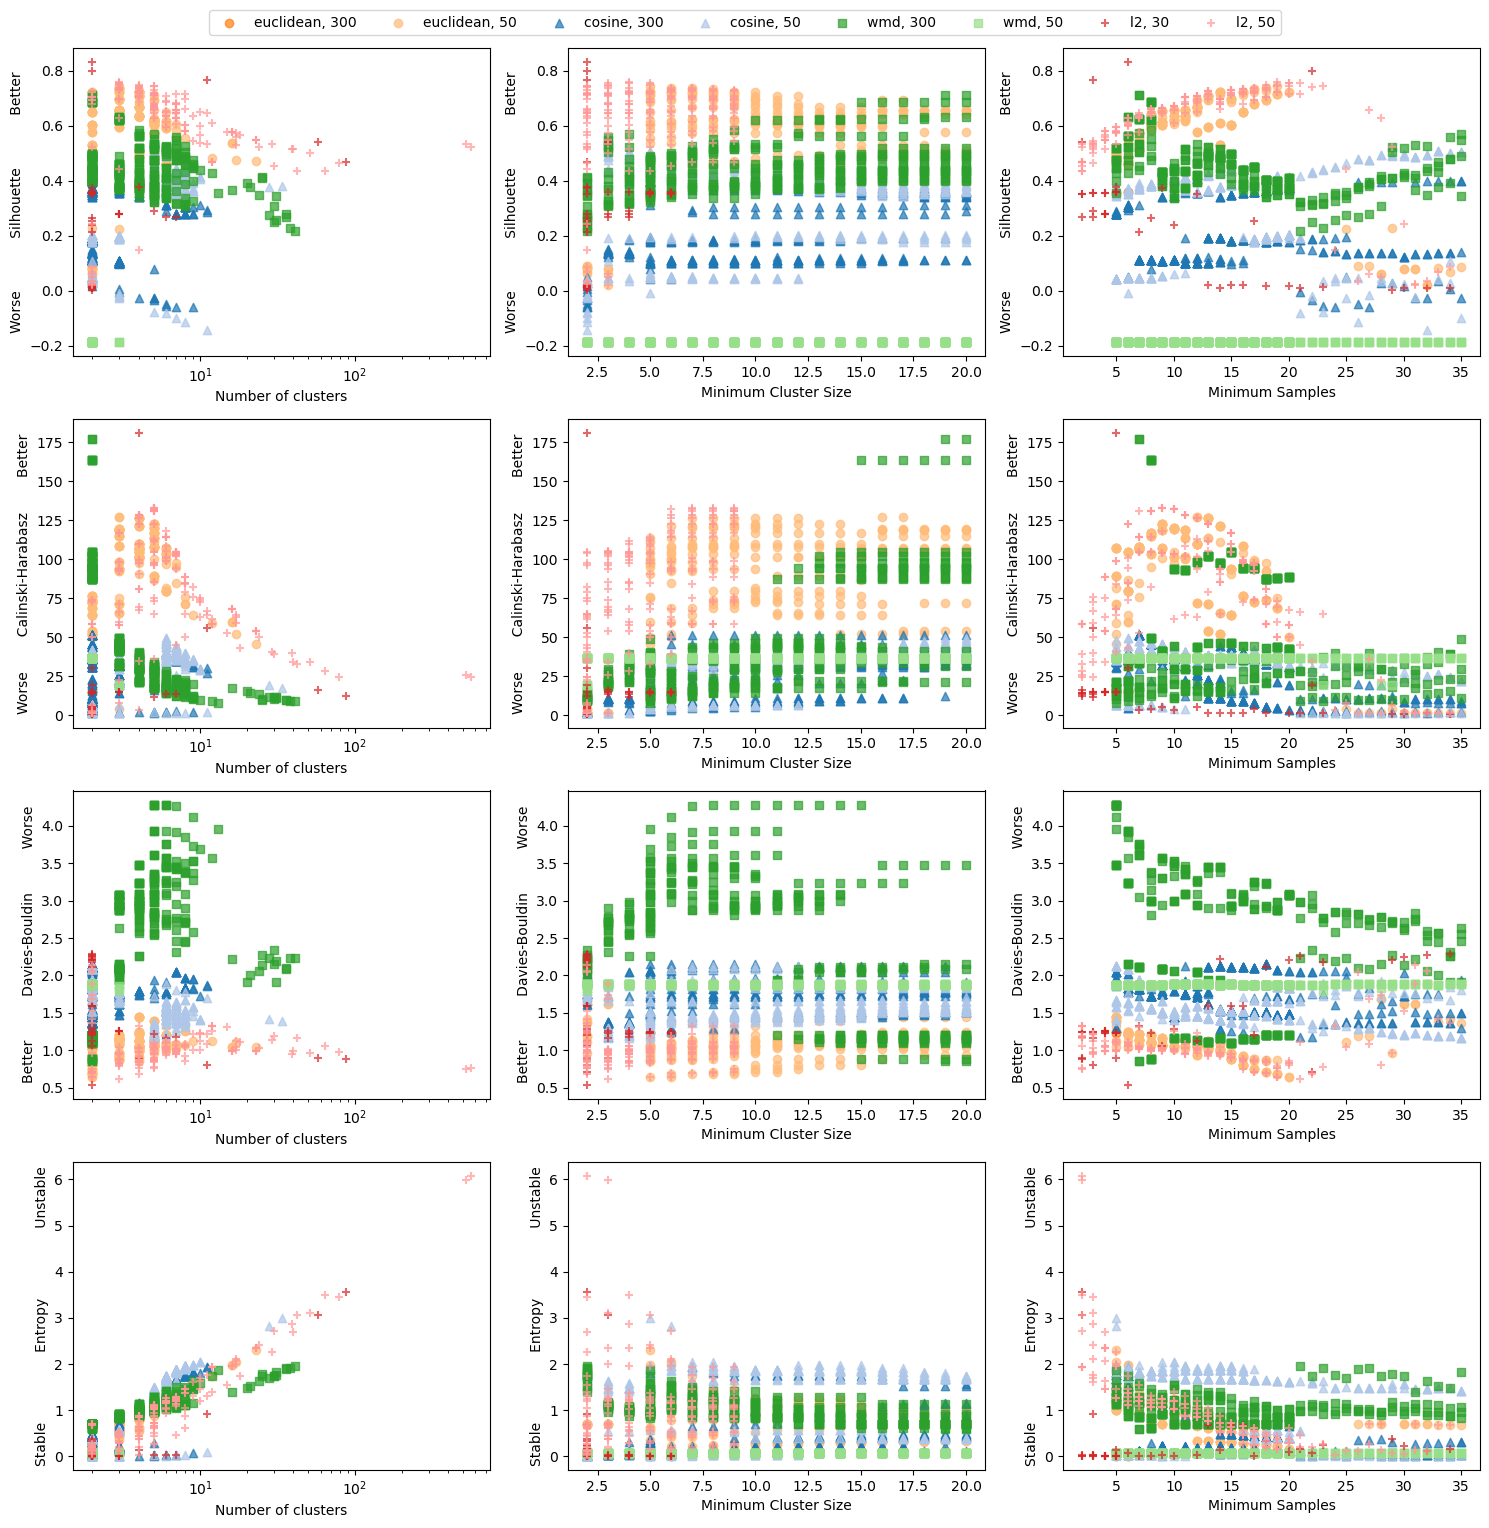

In [19]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


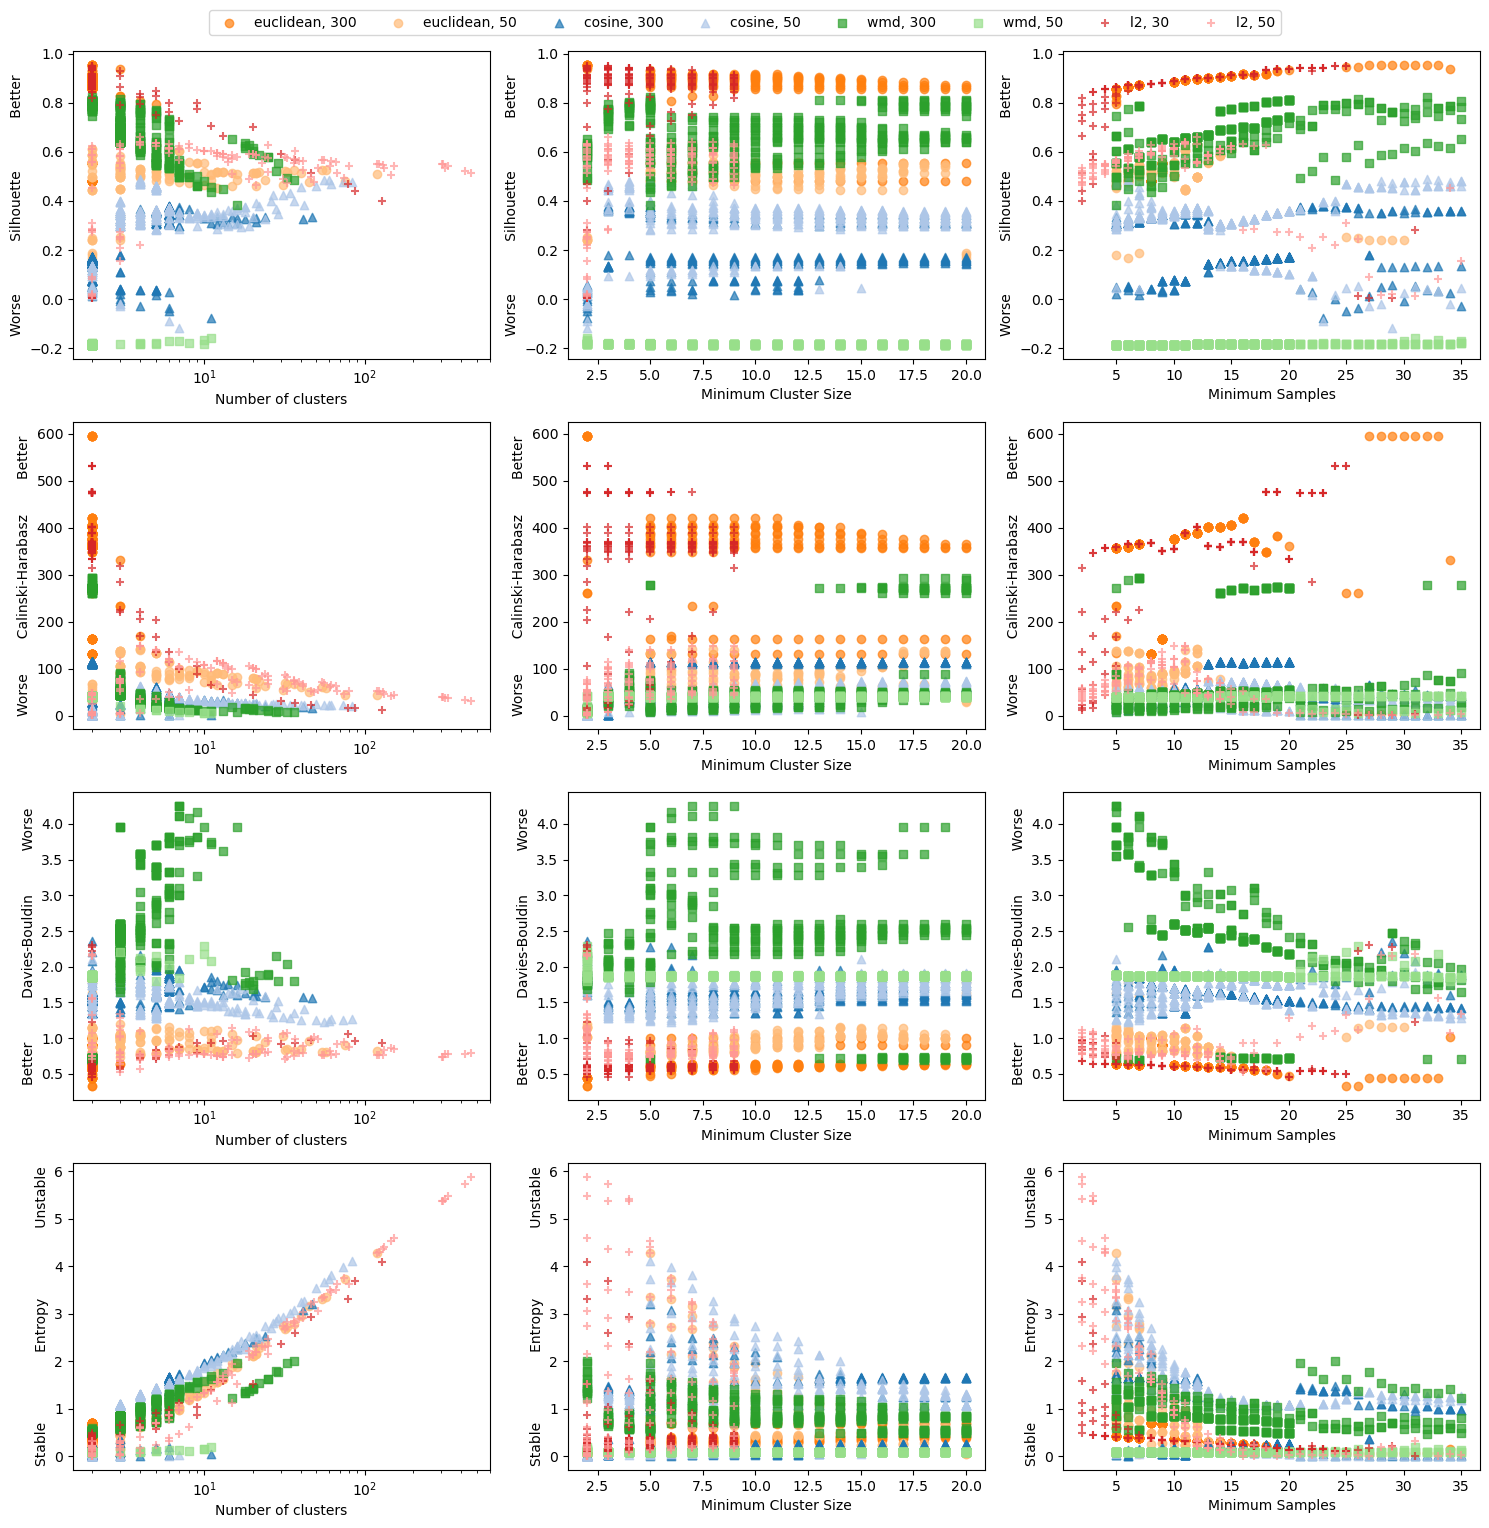

In [20]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


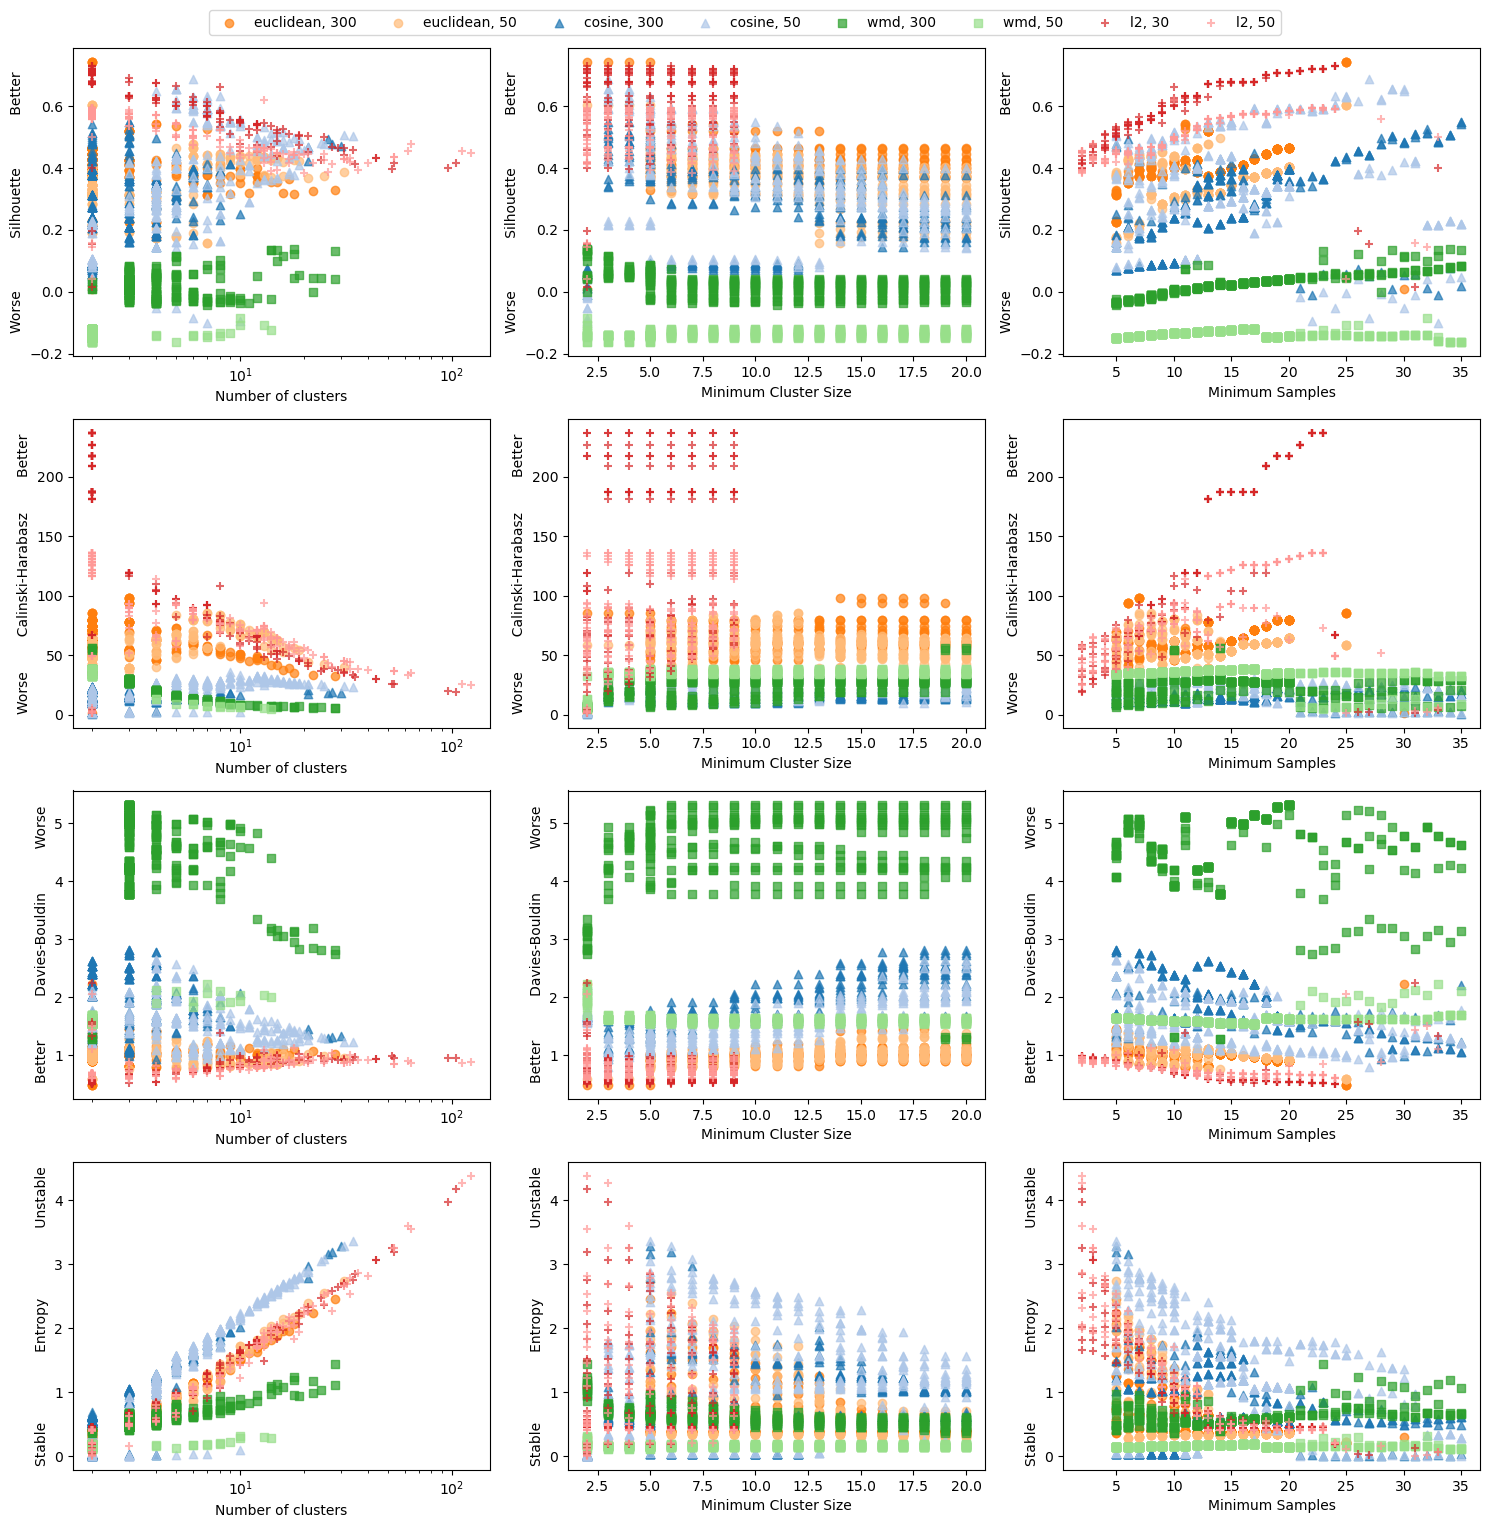

In [21]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()